The contents of this course including lectures, labs, homework assignments, and exams have all been adapted from the [Data 8 course at University California Berkley](https://data.berkeley.edu/education/courses/data-8). Through their generosity and passion for undergraduate education, the Data 8 community at Berkley has opened their content and expertise for other universities to adapt in the name of undergraduate education.

In [2]:
#!pip install datascience
from datascience import *
import numpy as np

from IPython.display import display, Math, Latex

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Chapter 15: Prediction

An important aspect of data science is to find out what data can tell us about the future. What do data about climate and pollution say about temperatures a few decades from now? Based on a person’s internet profile, which websites are likely to interest them? How can a patient’s medical history be used to judge how well he or she will respond to a treatment?

Let's load the Francis Galton data set on family and children heights that we have seen before. The table *heights* contains data on the midparent height and child’s height (all in inches) for a population of 934 adult “children”. Recall that the midparent height is an average of the heights of the two parents.

In [3]:
# Data on heights of parents and their adult children
original = Table.read_table('galton.csv')
heights = Table().with_columns(
    'MidParent', original.column('midparentHeight'),
    'Child', original.column('childHeight')
    )

In [4]:
heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


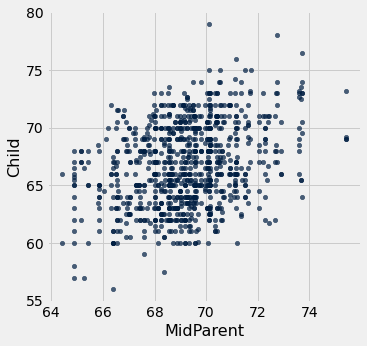

In [5]:
heights.scatter('MidParent')

A primary reason for studying the data was to be able to predict the adult height of a child born to parents who were similar to those in the dataset. We made these predictions in Section 8.1, after noticing the positive association between the two variables.

In [6]:
def predict_child(mpht):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of mpht.
    
    The prediction is the average height of the children 
    whose midparent height is in the range mpht plus or minus 0.5 inches.
    """
    
    close_points = heights.where('MidParent', are.between(mpht-0.5, mpht + 0.5))
    return close_points.column('Child').mean()                       

In [7]:
# Apply predict_child to all the midparent heights

heights_with_predictions = heights.with_column(
    'Prediction', heights.apply(predict_child, 'MidParent')
    )

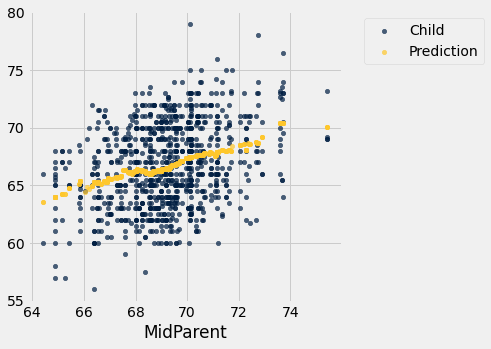

In [8]:
# Draw the original scatter plot along with the predicted values

heights_with_predictions.scatter('MidParent')

The prediction at a given midparent height lies roughly at the center of the vertical strip of points at the given height. This method of prediction is called regression. 

### Correlation
* In this section we will develop a measure of how tightly clustered a scatter diagram is about a straight line. Formally, this is called measuring linear association.

The table hybrid contains data on hybrid passenger cars sold in the United States from 1997 to 2013. The data were adapted from the online data archive of Prof. Larry Winner of the University of Florida. The columns:

   * vehicle: model of the car

   * year: year of manufacture

   * msrp: manufacturer’s suggested retail price in 2013 dollars

   * acceleration: acceleration rate in km per hour per second

   * mpg: fuel econonmy in miles per gallon

   * class: the model’s class.


In [9]:
hybrid = Table.read_table('hybrid.csv')
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


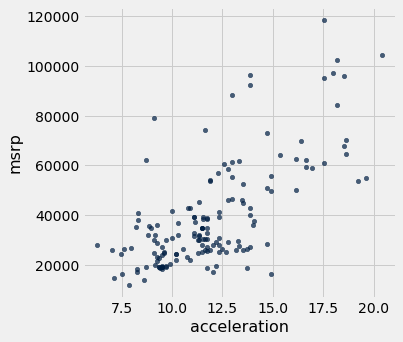

In [10]:
hybrid.scatter('acceleration', 'msrp')

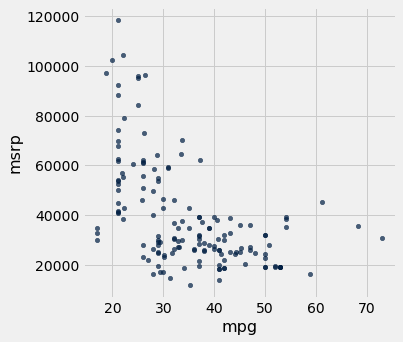

In [11]:
hybrid.scatter('mpg', 'msrp')

The above plot appears to be non-linear

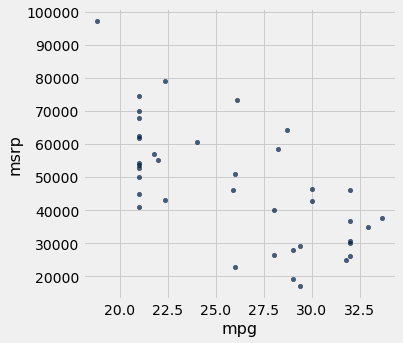

In [12]:
# Selecting 
suv = hybrid.where('class', 'SUV')
suv.scatter('mpg', 'msrp')

Whene selecting only SUVs the data is more linearly correlated.

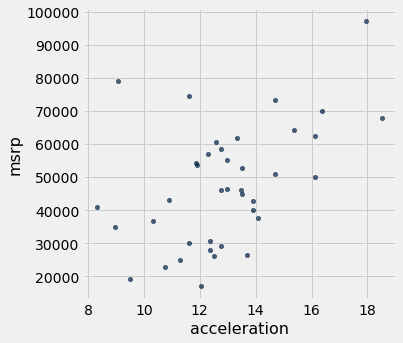

In [13]:
suv.scatter('acceleration', 'msrp')

We can derive useful information from the general orientation and shape of a scatter diagram even without paying attention to the units in which the variables were measured.

We can plot all the variables in standard units and the plots would look the same. This gives us a way to compare the degree of linearity in two scatter diagrams.

Recall that in an earlier section we defined the function standard_units to convert an array of numbers to standard units.

In [14]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

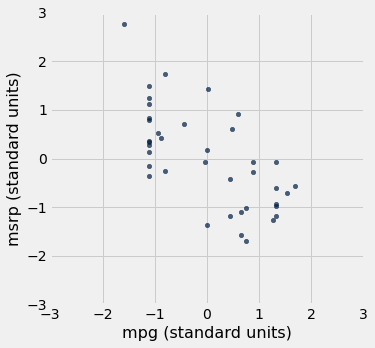

In [15]:
Table().with_columns(
    'mpg (standard units)',  standard_units(suv.column('mpg')), 
    'msrp (standard units)', standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

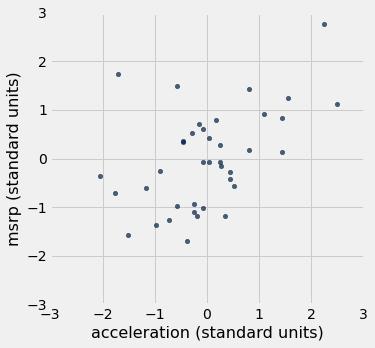

In [16]:
Table().with_columns(
    'acceleration (standard units)', standard_units(suv.column('acceleration')), 
    'msrp (standard units)',         standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

We will now define a measure that uses standard units to quantify the kinds of association that we have seen.

### The Correlation Coefficient

* The correlation coefficient measures how clustered the scatter diagram is around a straight line.

The term correlation coefficient isn’t easy to say, so it is usually shortened to correlation and denoted by $r$.

Here are some mathematical facts about $r$ that we will just observe by simulation.

* The correlation coefficient is a number between $-1$ and $1$.

* $r$ measures the extent to which the scatter plot clusters around a straight line.

* $r=1$ if the scatter diagram is a perfect straight line sloping upwards, and $r=-1$ if the scatter diagram is a perfect straight line sloping downwards.

Formula for $r$ is the average of the products of the two variables, when both variables are measured in standard units.

Here are the steps in the calculation. We will apply the steps to a simple table of values of $x$ and $y$.

In [17]:
x = np.arange(1, 7, 1)
y = make_array(2, 3, 1, 5, 2, 7)
t = Table().with_columns(
        'x', x,
        'y', y
    )
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


Based on the scatter diagram, we expect that $r$ will be positive but not equal to 1.

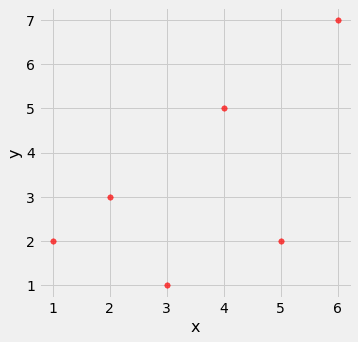

In [18]:
t.scatter(0, 1, s=30, color='red')

**Step 1.** Convert each variable to standard units.

In [19]:
t_su = t.with_columns(
        'x (standard units)', standard_units(x),
        'y (standard units)', standard_units(y)
    )
t_su

x,y,x (standard units),y (standard units)
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


**Step 2.** Multiply each pair of standard units.

In [20]:
t_product = t_su.with_column('product of standard units', t_su.column(2) * t_su.column(3))
t_product

x,y,x (standard units),y (standard units),product of standard units
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


**Step 3.** is the average of the products computed in Step 2.

In [21]:
# r is the average of the products of standard units

r = np.mean(t_product.column(4))
r

0.6174163971897709

As expected, $r$ is positive but not equal to 1.

### Properties of $r$

* $r$ is a pure number. It has no units.

* $r$ is based on standard units.

* $r$ is unaffected by changing the units on either axis. 

* $r$ is unaffected by switching the axes. Algebraically, this is because the product of standard units does not depend on which variable is called $x$ and which $y$. Geometrically, switching axes reflects the scatter plot about the line $y=x$, but does not change the amount of clustering nor the sign of the association.

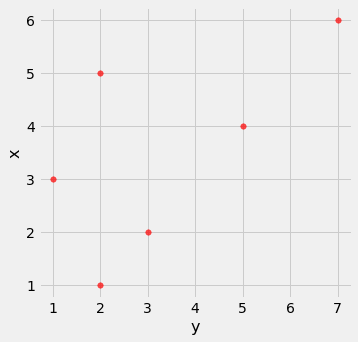

In [22]:
t.scatter('y', 'x', s=30, color='red')

We are going to be calculating correlations repeatedly so lets define a function that computes it by performing all the steps described above.

In [23]:
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

In [24]:
correlation(t, 'x', 'y')

0.6174163971897709

In [25]:
correlation(t, 'y', 'x')

0.6174163971897709

In [26]:
correlation(suv, 'mpg', 'msrp')

-0.6667143635709919

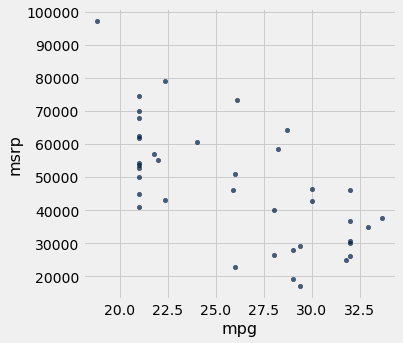

In [28]:
suv.scatter('mpg', 'msrp')

In [27]:
correlation(suv, 'acceleration', 'msrp')

0.48699799279959155

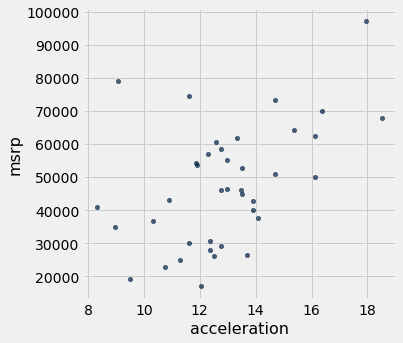

In [29]:
suv.scatter('acceleration', 'msrp')

#### Association is not Causation¶
Correlation only measures association. Correlation does not imply causation. Though the correlation between the weight and the math ability of children in a school district may be positive, that does not mean that doing math makes children heavier or that putting on weight improves the children’s math skills. Age is a confounding variable: older children are both heavier and better at math than younger children, on average.

Correlation measures only one kind of association – linear. Variables that have strong non-linear association might have very low correlation. Here is an example of variables that have a perfect quadratic relation $y=x^2$ but have correlation equal to 0.

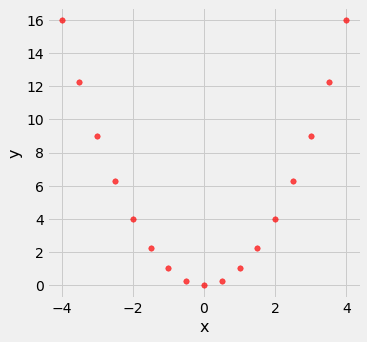

In [30]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [31]:
correlation(nonlinear, 'x', 'y')

0.0

Outliers can have a big effect on correlation. Here is an example where a scatter plot for which $r=1$ is turned into a plot for which $r=0$, by the addition of just one outlying point.

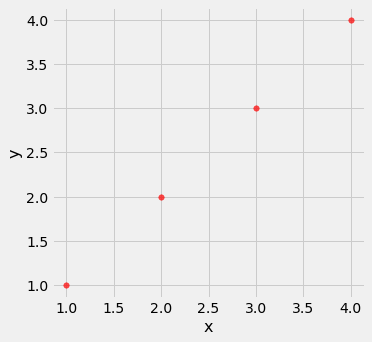

In [32]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')

In [33]:
correlation(line, 'x', 'y')

1.0

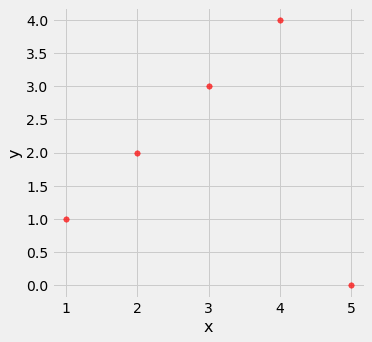

In [34]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [35]:
correlation(outlier, 'x', 'y')

0.0

In [37]:
.816**2

0.6658559999999999

### Ecological Correlations

Correlations based on aggregated data can be misleading. As an example, here are data on the Critical Reading and Math SAT scores in 2014. 

* All 50 states and Washington, D.C. 
* Participation Rate contains the percent of high school seniors who took the test


In [43]:
sat2014 = Table.read_table('sat2014.csv').sort('Combined', descending = True)
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
North Dakota,2.3,612,620,584,1816
Illinois,4.6,599,616,587,1802
Iowa,3.1,605,611,578,1794
South Dakota,2.9,604,609,579,1792
Minnesota,5.9,598,610,578,1786
Michigan,3.8,593,610,581,1784
Wisconsin,3.9,596,608,578,1782
Missouri,4.2,595,597,579,1771
Wyoming,3.3,590,599,573,1762
Kansas,5.3,591,596,566,1753


In [39]:
percentile(50, sat2014.column('Combined'))

1554

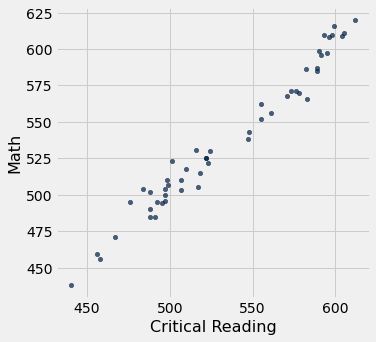

In [44]:
sat2014.scatter('Critical Reading', 'Math')

In [45]:
correlation(sat2014, 'Critical Reading', 'Math')

0.9847558411067433

The data in the table have been created by lumping all the students in each state into a single point at the average values of the two variables in that state. But not all students in the state will be at that point, as students vary in their performance. If you plot a point for each student instead of just one for each state, there will be a cloud of points around each point in the figure above. The overall picture will be more fuzzy. The correlation between the Math and Critical Reading scores of the students will be lower than the value calculated based on state averages.

Correlations based on aggregates and averages are called ecological correlations and are frequently reported. As we have just seen, they must be interpreted with care.

In 2012, a [paper](https://www.biostat.jhsph.edu/courses/bio621/misc/Chocolate%20consumption%20cognitive%20function%20and%20nobel%20laurates%20(NEJM).pdf) in the respected New England Journal of Medicine examined the relation between chocolate consumption and Nobel Prizes in a group of countries. The following graph, provided in the paper, should motivate you to go and take a look.

<img src="Correlation_65_0.png" width=600 height=600 />

Let's go back to the parent/child height data

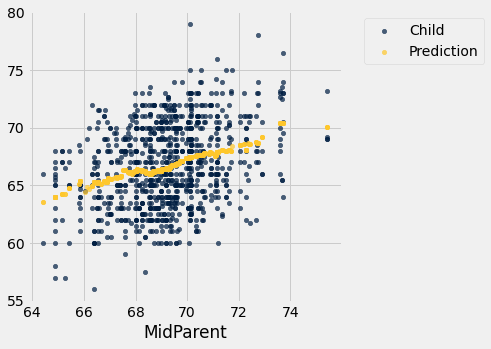

In [46]:
heights_with_predictions.scatter('MidParent')

We can convert the data into standard units and create a plot that looks exaclty like the one above

In [47]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz))/np.std(xyz)  

In [48]:
heights_SU = Table().with_columns(
    'MidParent SU', standard_units(heights.column('MidParent')),
    'Child SU', standard_units(heights.column('Child'))
)
heights_SU

MidParent SU,Child SU
3.45465,1.80416
3.45465,0.686005
3.45465,0.630097
3.45465,0.630097
2.47209,1.88802
2.47209,1.60848
2.47209,-0.348285
2.47209,-0.348285
1.58389,1.18917
1.58389,0.350559


In [49]:
def predict_child_su(mpht_su):
    """Return a prediction of the height (in standard units) of a child 
    whose parents have a midparent height of mpht_su in standard units.
    """
    close = 0.5/sd_midparent
    close_points = heights_SU.where('MidParent SU', are.between(mpht_su-close, mpht_su + close))
    return close_points.column('Child SU').mean()   

In [50]:
sd_midparent = np.std(heights.column(0))
sd_midparent

1.8014050969207571

In [51]:
heights_with_su_predictions = heights_SU.with_column(
    'Prediction SU', heights_SU.apply(predict_child_su, 'MidParent SU')
    )

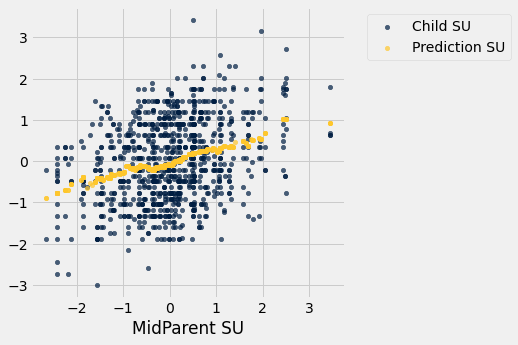

In [52]:
heights_with_su_predictions.scatter('MidParent SU')

### The Equation of the Regression Line

In regression, we use the value of one variable (which we will call $x$) to predict the value of another (which we will call $y$). When the variables and are measured in standard units, the regression line for predicting $y$ based on $x$ has slope $r$ and passes through the origin. Thus the equation of the regression line can be written as: $\mbox{estimate of }y ~=~ r \cdot x ~~~
\mbox{when both variables are measured in standard units} $

In the original units of the data, this becomes 

$ \frac{\mbox{estimate of}~y ~-~\mbox{average of}~y}{\mbox{SD of}~y} ~=~ r \times \frac{\mbox{the given}~x ~-~\mbox{average of}~x}{\mbox{SD of}~x}$

<img src="regline.png" width=600 height=600 />

The slope and intercept of the regression line in original units can be derived from the diagram above.

$\mathbf{\mbox{slope of the regression line}} ~=~ r \cdot
\frac{\mbox{SD of }y}{\mbox{SD of }x} $

$\mathbf{\mbox{intercept of the regression line}} ~=~
\mbox{average of }y ~-~ \mbox{slope} \cdot \mbox{average of }x
$

The three functions below compute the correlation, slope, and intercept.

In [53]:
def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

In [54]:
family_r = correlation(heights, 'MidParent', 'Child')
family_r

0.32094989606395924

In [55]:
family_slope = slope(heights, 'MidParent', 'Child')
family_intercept = intercept(heights, 'MidParent', 'Child')
family_slope, family_intercept

(0.637360896969479, 22.63624054958975)

The equation of the regression line is

$  \mbox{estimate of child's height} ~=~ 0.64 \cdot \mbox{midparent height} ~+~ 22.64 $

This is also known as the regression equation. The principal use of the regression equation is to predict $y$ based on $x$.

For example, for a midparent height of 70.48 inches, the regression equation predicts the child’s height to be 67.56 inches.

In [56]:
family_slope * 70.48 + family_intercept

67.55743656799862

Our original prediction, created by taking the average height of all children who had midparent heights close to 70.48, came out to be pretty close: 67.63 inches compared to the regression line’s prediction of 67.55 inches.

In [57]:
heights_with_predictions.where('MidParent', are.equal_to(70.48)).show(3)

MidParent,Child,Prediction
70.48,74,67.6342
70.48,70,67.6342
70.48,68,67.6342


In [58]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction', family_slope * heights.column('MidParent') + family_intercept
)
heights_with_predictions

MidParent,Child,Prediction,Regression Prediction
75.43,73.2,70.1,70.7124
75.43,69.2,70.1,70.7124
75.43,69,70.1,70.7124
75.43,69,70.1,70.7124
73.66,73.5,70.4158,69.5842
73.66,72.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
72.06,71,68.5025,68.5645
72.06,68,68.5025,68.5645


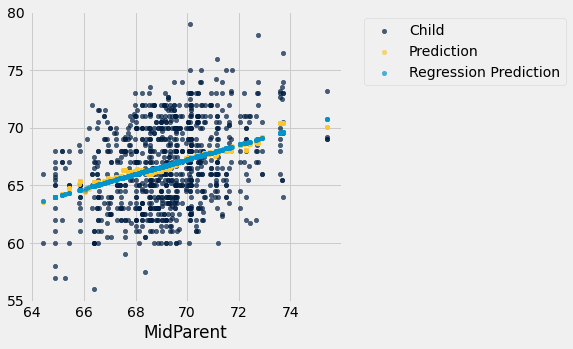

In [59]:
heights_with_predictions.scatter('MidParent')

The blue dots show the regression predictions

The predictions all lie on the line and are known as the “fitted values”. The function ***fit*** takes the name of the table and the labels of $x$ and $y$, and returns an array of fitted values.

In [60]:
def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

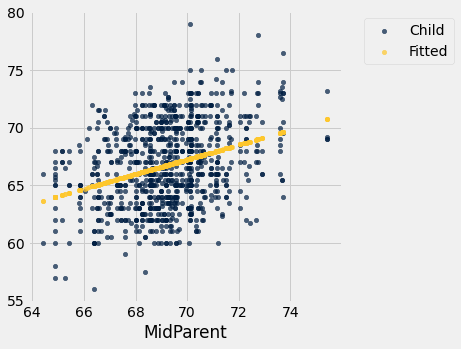

In [61]:
heights.with_column('Fitted', fit(heights, 'MidParent', 'Child')).scatter('MidParent')

Another way to draw the line is to use the option ***fit_line=True*** with the Table method ***scatter***.

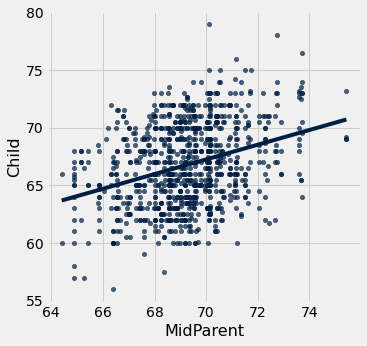

In [62]:
heights.scatter('MidParent', fit_line=True)

The slope is a ratio, and it worth taking a moment to study the units in which it is measured.

In [63]:
slope(heights, 'MidParent', 'Child')

0.637360896969479

The slope of the regression line is about 0.64 child inches per midparent height in inches. This means that for parents whos mid-heights are 1 inch apart our prediction of child height will differ by about 0.64 inches.

### The Method of Least Squares

We will use the text “Little Women” to estimate the number of characters (that is, letters, spaces punctuation marks, and so on) based on the number of periods.

In [65]:
little_women = Table.read_table('little_women.csv')
little_women = little_women.move_to_start('Periods')
little_women

Periods,Characters
189,21759
188,22148
231,20558
195,25526
255,23395
140,14622
131,14431
214,22476
337,33767
185,18508


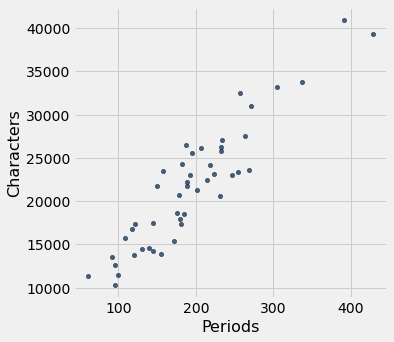

In [66]:
little_women.scatter('Periods', 'Characters')

In [67]:
correlation(little_women, 'Periods', 'Characters')

0.9229576895854816

The scatter plot is remarkably close to linear, and the correlation is more than 0.92.

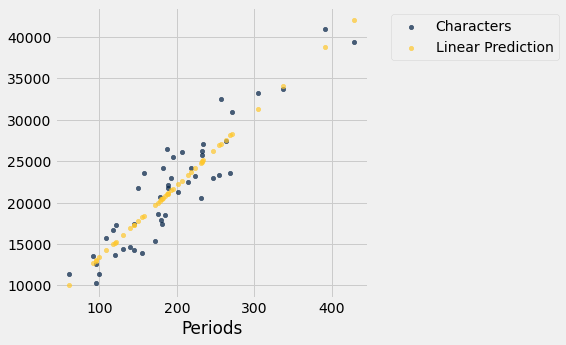

In [68]:
lw_with_predictions = little_women.with_column('Linear Prediction', fit(little_women, 'Periods', 'Characters'))
lw_with_predictions.scatter('Periods')

Corresponding to each point on the scatter plot, there is an error of prediction calculated as the actual value minus the predicted value. It is the vertical distance between the point and the line, with a negative sign if the point is below the line.

In [69]:
actual = lw_with_predictions.column('Characters')
predicted = lw_with_predictions.column('Linear Prediction')
errors = actual - predicted

In [70]:
lw_with_predictions.with_column('Error', errors)

Periods,Characters,Linear Prediction,Error
189,21759,21183.6,575.403
188,22148,21096.6,1051.38
231,20558,24836.7,-4278.67
195,25526,21705.5,3820.54
255,23395,26924.1,-3529.13
140,14622,16921.7,-2299.68
131,14431,16138.9,-1707.88
214,22476,23358,-882.043
337,33767,34056.3,-289.317
185,18508,20835.7,-2327.69


We can use slope and intercept to calculate the slope and intercept of the fitted line. The graphs below shows the line of fit for a few possible regression lines. The errors corresponding to four of the points are shown in red. There is nothing special about those four points. They were just chosen for clarity of the display. 

In [71]:
lw_reg_slope = slope(little_women, 'Periods', 'Characters')
lw_reg_intercept = intercept(little_women, 'Periods', 'Characters')
print("slope:", lw_reg_slope,  "intercept:", lw_reg_intercept)

slope: 86.97784125829821 intercept: 4744.784796574928


<img src="Method_of_Least_Squares_17_1.png" width=400 height=400 />

<img src="Method_of_Least_Squares_19_0.png" width=400 height=400 />

<img src="Method_of_Least_Squares_20_0.png" width=400 height=400 />

If you use any arbitrary line to calculate your estimates, then some of your errors are likely to be positive and others negative. To avoid cancellation when measuring the rough size of the errors, we will take the mean of the squared errors rather than the mean of the errors themselves.

The mean squared error of estimation is a measure of roughly how big the squared errors are, but as we have noted earlier, its units are hard to interpret. Taking the square root yields the root mean square error (rmse), which is in the same units as the variable being predicted and therefore much easier to understand.

* To get estimates of $y$ based on $x$, you can use any line you want.

* Every line has a root mean squared error of estimation.

* “Better” lines have smaller errors.

If we use the line

$\mbox{prediction} ~=~ ax + b$

it will have an mse that depends on the slope and the intercept . The function lw_rmse takes the slope and intercept as its arguments and returns the corresponding rmse.


In [72]:
def lw_rmse(any_slope, any_intercept):
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)**0.5

Let’s check that lw_mse gets the right answer for the root mean squared error of the regression line. 

In [73]:
print("slope:", lw_reg_slope,  "intercept:", lw_reg_intercept)

slope: 86.97784125829821 intercept: 4744.784796574928


In [74]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

2701.690785311856

In [75]:
lw_rmse(-100, 50000)

16710.11983735375

In [76]:
lw_rmse(90, 4000)

2715.5391063834586

**The regression line is the unique straight line that minimizes the mean squared error of estimation among all straight lines.**

If we experiment with different values, we can find a low-error slope and intercept through trial and error, but that would take a while. Fortunately, there is a Python function that does all the trial and error for us.

The ***minimize*** function can be used to find the arguments of a function for which the function returns its minimum value. Python uses a similar trial-and-error approach, following the changes that lead to incrementally lower output values. 

The argument of minimize is a function that itself takes numerical arguments and returns a numerical value. For example, the function lw_rmse takes a numerical slope and intercept as its arguments and returns the corresponding mse.

In [77]:
best = minimize(lw_rmse)
best

array([  86.97784126, 4744.78481477])

In [78]:
print("slope from formula:        ", lw_reg_slope)
print("slope from minimize:       ", best.item(0))
print("intercept from formula:    ", lw_reg_intercept)
print("intercept from minimize:   ", best.item(1))

slope from formula:         86.97784125829821
slope from minimize:        86.97784125845317
intercept from formula:     4744.784796574928
intercept from minimize:    4744.784814765519


We have found not only that the regression line minimizes root mean squared error, but also that minimizing mean squared error gives us the regression line. The regression line is the only line that minimizes mean squared error.

That is why the regression line is sometimes called the “least squares line.”

### Nonlinear Regression

Sometimes data may be curved and it is better to fit a curve than a straight line. The [study](https://digitalcommons.wku.edu/ijes/vol6/iss2/10/) postulated a quadratic relation between the weight lifted and the shot put distance. So let’s use quadratic functions as our predictors and see if we can find the best one.

We have to find the best quadratic function among all quadratic functions, instead of the best straight line among all straight lines. The method of least squares allows us to do this.

The mathematics of this minimization is complicated and not easy to see just by examining the scatter plot. But numerical minimization is just as easy as it was with linear predictors! We can get the best quadratic predictor by once again using minimize. Let’s see how this works.

Recall that a quadratic function has the form

$f(x) ~=~ ax^2 + bx + c$


for constants $a$, $b$, and $c$.

To find the best quadratic function to predict distance based on weight lifted, using the criterion of least squares, we will first write a function that takes the three constants as its arguments, calculates the fitted values by using the quadratic function above, and then returns the mean squared error.

The function is called shotput_quadratic_mse. Notice that the definition is analogous to that of lw_mse, except that the fitted values are based on a quadratic function instead of linear.

In [80]:
shotput = Table.read_table('shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


In [81]:
def shotput_quadratic_mse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = a*(x**2) + b*x + c
    return np.mean((y - fitted) ** 2)**0.5

In [82]:
best = minimize(shotput_quadratic_mse)
best

array([-1.04003731e-03,  2.82706003e-01, -1.53167618e+00])

Our prediction of the shot put distance for an athlete who lifts $x$ kilograms is about

$-0.00104x^2 ~+~ 0.2827x - 1.5318$

meters. For example, if the athlete can lift 100 kilograms, the predicted distance is 16.33 meters. On the scatter plot, that’s near the center of a vertical strip around 100 kilograms.

In [83]:
(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

In [84]:
x = shotput.column(0)
shotput_fit = best.item(0)*(x**2) + best.item(1)*x + best.item(2)

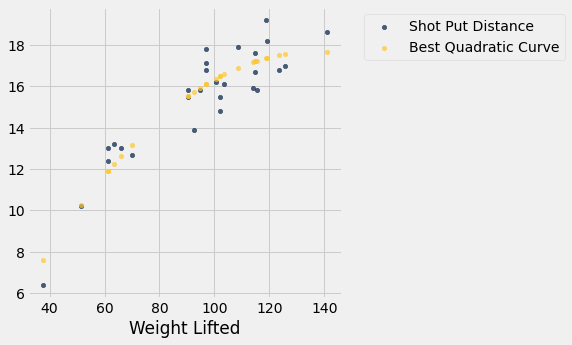

In [85]:
shotput.with_column('Best Quadratic Curve', shotput_fit).scatter(0)

### Visual Diagnostics

Suppose a data scientist has decided to use linear regression to estimate values of one variable (called the response variable) based on another variable (called the predictor). To see how well this method of estimation performs, the data scientist must measure how far off the estimates are from the actual values. These differences are called residuals.

$\mbox{residual} ~=~ \mbox{observed value} ~-~ \mbox{regression estimate}$


Residuals are the vertical distances of the points from the regression line. There is one residual for each point in the scatter plot. 

$\mbox{residual} ~~ = ~~ y ~-~
\mbox{fitted value of }y
~~ = ~~ y ~-~
\mbox{height of regression line at }x$

The function residual calculates the residuals. The calculation assumes all the relevant functions we have already defined: standard_units, correlation, slope, intercept, and fit.

In [86]:
def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

In [87]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )
heights

MidParent,Child,Fitted Value,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


It is better to plot the data.

In [88]:
def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

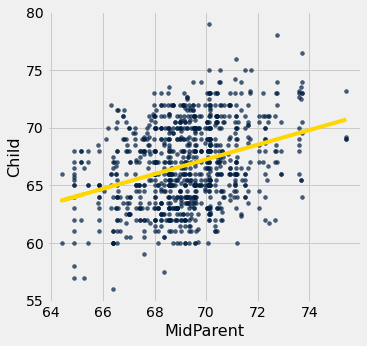

In [89]:
scatter_fit(heights, 'MidParent', 'Child')

In [90]:
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

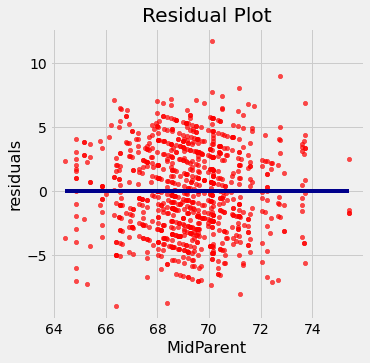

In [91]:
residual_plot(heights, 'MidParent', 'Child')

The midparent heights are on the horizontal axis, as in the original scatter plot. But now the vertical axis shows the residuals. Notice that the plot appears to be centered around the horizontal line at the level 0 (shown in dark blue). Notice also that the plot shows no upward or downward trend. We will observe later that this lack of trend is true of all regressions.

**The residual plot of a good regression shows no pattern. The residuals look about the same, above and below the horizontal line at 0, across the range of the predictor variable.**

The function regression_diagnostic_plots draws the original scatter plot as well as the residual plot for ease of comparison.

In [92]:
def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)

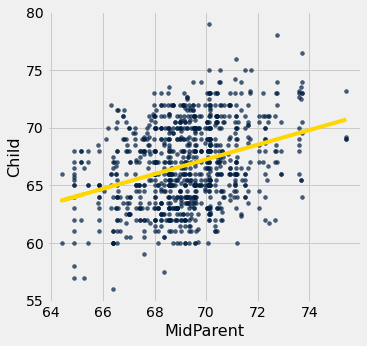

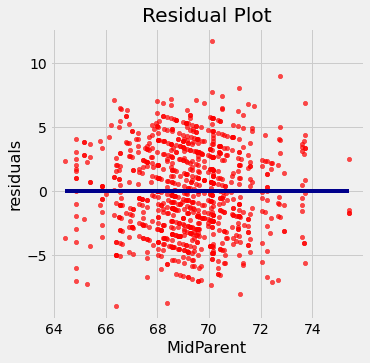

In [93]:
regression_diagnostic_plots(heights, 'MidParent', 'Child')

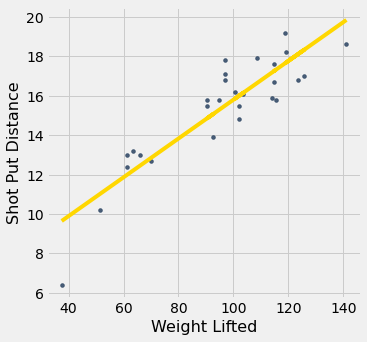

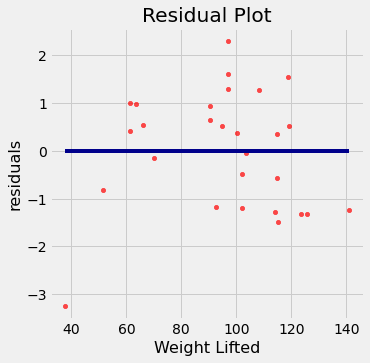

In [94]:
regression_diagnostic_plots(shotput, 'Weight Lifted', 'Shot Put Distance')

When a residual plot shows a pattern or heteroscedasticity (uneven spread), there may be a non-linear relation between the variables.